In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
try:
    # https://stackoverflow.com/questions/57105747/modulenotfounderror-no-module-named-plotly-graph-objects/57112843
    #     import plotly.graph_objects as go
    #     import plotly.express as px
    import plotly.express as px
    import plotly.graph_objects as go
except ImportError as e:
    from plotly import graph_objs as go
    from plotly import express as px
# import plotly.express as px
# import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
# from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
# !pip install pyramid-arima
# from pyramid.arima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)
# out
# filename=r"G:\file\学校\可视化\大作业\COVID-19\COVID-19-Data-master\US\County_level_summary\US_County_summary_covid19_confirmed_transpose.csv"

state_filename_base=r"G:\file\学校\可视化\大作业\COVID-19\COVID-19-Data-master\US\State_level_summary\US_State_summary_covid19_{}_trpo.xlsx"
# state_filename_base=r"COVID-19-Data-master\US\State_level_summary\US_State_summary_covid19_{}_trpo.xlsx"
# state_filename_base=r"COVID-19-Data-master/US/State_level_summary/US_State_summary_covid19_{}_trpo.xlsx"


# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


def get_sum(type_name):

    df = pd.read_excel(state_filename_base.format(type_name))
    # pd 每一列 求和
    df_sum = df.sum()
    # print("df_sum")
    # print(df_sum)
    return df_sum


def get_3type_df():
    df_confirmed = pd.read_excel(state_filename_base.format("confirmed"))
    df_recovered = pd.read_excel(state_filename_base.format("recovered"))
    df_death = pd.read_excel(state_filename_base.format("death"))
    # df=

    df=pd.DataFrame({})
    df["confirmed"]=get_sum("confirmed")
    df["recovered"]=get_sum("recovered")
    df["death"]=get_sum("death")
    # print("df_death")
    # print(df_death)
    # print("df_death.shape")
    # print(df_death.shape)
    return df
covid=get_3type_df()

confirmed_col="confirmed"
recovered_col="recovered"
death_col="death"

datewise=covid
# yy=datewise[confirmed_col]-datewise[recovered_col]-datewise[death_col]
# print("yy")
# print(yy)
# print("datewise.index")
# print(datewise.index)
# 总的 和
# 根据不同的 couty
# 确诊的 - 治愈的 - 死亡的
# 就是现在还在患病的
# 分配  Distribution 分布
countrywise=datewise
# countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
# countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

countrywise["Mortality"]=(countrywise[death_col]/countrywise[confirmed_col])*100
countrywise["Recovery"]=(countrywise[recovered_col]/countrywise[confirmed_col])*100

# fig=px.bar(x=datewise.index,y=datewise[confirmed_col]-datewise[recovered_col]-datewise[death_col])
# fig.update_layout(title="Distribution of Number of Active Cases 累计患病的分布(各个县)",
#                   xaxis_title="县",yaxis_title="Number of Cases 患病的个数",)
# # xaxis_title="Date",yaxis_title="Number of Cases",
# fig.show()

# 正在患病的分布(各个县)"
# 为什么没有显示呢

X=countrywise[["Mortality","Recovery"]]
# 死亡率 Mortality
#Standard Scaling since K-Means Clustering is a distance based alogrithm
#标准缩放，因为K-均值聚类是一种基于距离的算法
X=std.fit_transform(X)

wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

def example():

    x=np.arange(2,11)
    plt.figure(figsize=(10,5))
    plt.plot(x,wcss,marker='o')
    plt.xlabel("Number of Clusters 集群的个数 ")
    # 集群;群集;
    plt.ylabel("Within Cluster Sum of Squares (WCSS) 簇内平方和")
    # 簇内平方和（WCSS）
    plt.title("Elbow Method 肘部法则")
    # –Elbow Method和轮廓...
    # 肘部法则
    plt.show()

# countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
# countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

import scipy.cluster.hierarchy as sch
# 等级制度(尤指社会或组织); 统治集团; 层次体系; hierarchy
#

def HierarchicalClusteringTest():
    plt.figure(figsize=(20,15))
    # dendrogram 系统树图（一种表示亲缘关系的树状图解）;
    # 连接; 联系; 链环; 连锁; 联动装置; linkage

    dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))
    # dendogram.

    plt.show()

clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

countrywise["Clusters"]=clf_final.predict(X)

cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),
                           countrywise[countrywise["Clusters"]==2].head(15),
                           countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")
# plt.show()
# print("cluster_summary")
# print(cluster_summary)


,confirmed,recovered,death,Mortality,Recovery,Clusters
Connecticut,112412118.00,0.00,3436448.00,3.06,0.00,1.00
District of Columbia,17657996.00,0.00,460675.00,2.61,0.00,1.00
Massachusetts,221315696.00,0.00,7205123.00,3.26,0.00,1.00
Michigan,295628347.00,0.00,7365116.00,2.49,0.00,1.00
New Jersey,334801563.00,0.00,11054685.00,3.30,0.00,1.00
New York,696697335.00,0.00,22868829.00,3.28,0.00,1.00
Pennsylvania,378669082.00,0.00,9564450.00,2.53,0.00,1.00
South Dakota,43223765.00,0.00,658377.00,1.52,0.00,2.00
Tennessee,294805484.00,0.00,4060985.00,1.38,0.00,2.00
Utah,138789349.00,0.00,762311.00,0.55,0.00,2.00


In [4]:
cluster_summary

,confirmed,recovered,death,Mortality,Recovery,Clusters
Connecticut,112412118,0,3436448,3.057008,0.0,1
District of Columbia,17657996,0,460675,2.608875,0.0,1
Massachusetts,221315696,0,7205123,3.255586,0.0,1
Michigan,295628347,0,7365116,2.491343,0.0,1
New Jersey,334801563,0,11054685,3.301862,0.0,1
New York,696697335,0,22868829,3.282463,0.0,1
Pennsylvania,378669082,0,9564450,2.525807,0.0,1
South Dakota,43223765,0,658377,1.523183,0.0,2
Tennessee,294805484,0,4060985,1.377513,0.0,2
Utah,138789349,0,762311,0.549258,0.0,2


In [5]:
def separate(countrywise):
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
    plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
                color='red',linestyle="--",label="Mean Recovery Rate around the World")
    plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
                color='black',linestyle="--",label="Mean Mortality Rate around the World")
    plt.legend()

separate(countrywise)

KeyError: 'Recovered'

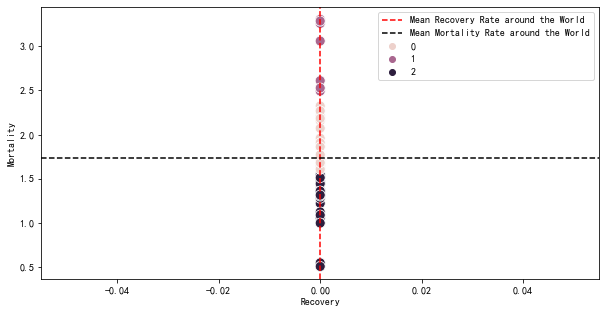

In [6]:
def separate(countrywise):
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
    plt.axvline(countrywise["Recovery"].mean(),color='red',linestyle="--",label="Mean Recovery Rate around the World")
    plt.axhline(countrywise["Mortality"].mean(),
                color='black',linestyle="--",label="Mean Mortality Rate around the World")
    plt.legend()

separate(countrywise)